# Inverse Kinematics from DH Parameters

Author: Michael Greer

This notebook shows how to build up to inverse kinematics starting from Denavit-Hartenberg (DH) Parameters. This is not intended to be an introduction to DH parameters themselves; check out [this video](https://www.youtube.com/watch?v=rA9tm0gTln8) for an overview on how DH parameters work. There are lots of other resources that cover how these work, including most robotics textbooks and blog entries around the web.

The DH parameters used here are for the [Sixi robot](https://www.marginallyclever.com/products/sixi-robot-arm/), an Open-Source, 6-DOF robot arm from the good folks at Marginally Clever. The code can be easily refactored to work with any set of DH parameters.

In [42]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sympy as sp

### DH Table

The DH parameters for a robot are typically specified in a DH table, where each row contains the parameters describing the transformation from one joint to the next. Each row needs a *theta*, *d*, *a*, and *alpha* value. Some sources use *r* instead of *a*, but they refer to the same parameter. For each joint, either *d* or *theta* is left for the variable joint value, depending on if the joint is linear or rotational, respectively. On this robot, the joints are each rotational, so the joint values all refer to the angle of each joint. The DH parameters are laid out in a list below.

In [43]:
# list of DH parameters
# Structure is d, theta, a, alpha in each row

# The theta angles are also referred to as qi

# Tells the code how many joint values to expect
DOF = 6

q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')

# Value of pi from the symbolic library for convenience
spi = sp.pi

# Define DH table

DH_params = []

DH_params.append([19.7452, q1, 0, -spi/2])
DH_params.append([0, q2, 35.796, 0])
DH_params.append([0, q3, 6.4259, -spi/2])
DH_params.append([38.705, q4, 0, spi/2])
DH_params.append([0, q5, 0, -spi/2])
DH_params.append([3.795, q6, 0, 0])
DH_params.append([2.75, 0, 0, 0])

DH_params

[[19.7452, q1, 0, -pi/2],
 [0, q2, 35.796, 0],
 [0, q3, 6.4259, -pi/2],
 [38.705, q4, 0, pi/2],
 [0, q5, 0, -pi/2],
 [3.795, q6, 0, 0],
 [2.75, 0, 0, 0]]

### Transformations

Now that we have all of the DH parameters, we can define a function that takes these parameters and turns them into a transformation matrix. Transformation matrices consist of a rotation matrix and a vector that allows us to define the location of points in space relative to different joints. We can create the transformations from each of the joints to the next, and then combine them all to get the transformations from each joint to the end effector. We talk about transformation matrices converting between "frames" or "spaces" that, in this case, correspond to each joint.

The following function generates a transformation matrix based on the DH parameters for one joint. The function after that generates a list of all of the transformation matrices for every joint.

In [27]:
# Using the combined DH transformation matrix
def DH_trans_matrix(params):
    
    d, theta, a, alpha = (params[0], params[1], params[2], params[3])
    
    mat = sp.Matrix([[sp.cos(theta), -1*sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha),    a*sp.cos(theta)],
                    [sp.sin(theta), sp.cos(theta)*sp.cos(alpha),    -1*sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
                    [0,             sp.sin(alpha),                  sp.cos(alpha),                  d],
                    [0,             0,                              0,                              1]])
    
    return mat

In [28]:
# Get the transformations from the origin to each of the joints and the end effector
def joint_transforms(DH_params):
    transforms = []

    transforms.append(sp.eye(4)) #Assuming the first first joint is at the origin

    for el in DH_params:

        transforms.append(DH_trans_matrix(el))

    return transforms



### Jacobian

Just like in the previous notebook on inverse kinematics, we are using the jacobian pseudoinversion method to solve the inverse kinematics. However, the method we're using to calculate the jacobian is different. Instead of using the differentiation method, we can calculate the jacobian column by column as follows:

$$ J_{i}=\begin{bmatrix}z_{i-1}\times (o_{n}-o_{i-1}) \\ z_{i-1}\end{bmatrix}$$

Where $z_{i-1}$ is the z-axis of the joint this column corresponds to (aka the axis the joint rotates around), $o_{i-1}$ is the origin of the frame of that joint, and $o_{n}$ is the origin of the end effector frame. This makes intuitive sense, if we consider the difference in frame origins to be the radius from the current joint to the end effector. The joint moves the end effector in a direction perpendicular to the radius with a speed proportional to the length of the radius, hence the cross product. The following diagram illustrates this:

![Diagram](Vectors.png)

For the sake of clarity, all three of these vectors point in mutually perpendicular directions. If you use the right hand rule to rotate the radius around the axis of rotation, it is clear that the end of the radius moves in the direction of J.

This method works just as well, and is very convenient if you already have access to the transformation matrices since the origin and z-axis vectors are the third and fourth columns of the transformation matrix, as shown:

$$ T_{i}^{0}=\begin{bmatrix}x_{i} & y_{i} & z_{i} & o_{i} \\ 0 & 0 & 0 & 1\end{bmatrix} $$

This is the transformation matrix of for joint frame i in the world frame. So, we already know the axes of the joint frame in terms of the home frame. The following function generates a symbolic expression for the jacobian using DH parameters. The function after that takes in a symbolic expression for the jacobian and solves it for specific joint values.

In [29]:
# To get the jacobain we can use the cross product method since we have all of the transformations

# Get the total transformation to the end effector
# This function gives the symbolic expression for the jacobian
def jacobian_expr(DH_params):

    transforms = joint_transforms(DH_params)

    trans_EF = transforms[0]

    for mat in transforms[1:]:

        trans_EF = trans_EF * mat

    pos_EF = trans_EF[0:3,3]

    J = sp.zeros(6, DOF)

    for joint in range(DOF):

        trans_joint = transforms[0]

        for mat in transforms[1:joint+1]:

            trans_joint = trans_joint*mat

        z_axis = trans_joint[0:3,2]

        pos_joint = trans_joint[0:3,3]

        Jv = z_axis.cross(pos_EF - pos_joint)

        Jw = z_axis

        J[0:3,joint] = Jv
        J[3:6,joint] = Jw

    J = sp.simplify(J)
    return J

In [30]:
# This function evaluates a symbolic jacobian expression using provided joint angles
def jacobian_subs(joints, jacobian_sym):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    J_l = jacobian_sym
    
    J_l = J_l.subs(q1, joints[0])
    J_l = J_l.subs(q2, joints[1])
    J_l = J_l.subs(q3, joints[2])
    J_l = J_l.subs(q4, joints[3])
    J_l = J_l.subs(q5, joints[4])
    J_l = J_l.subs(q6, joints[5])
    
    return J_l

In [31]:
# Verify the two previous functions

# If you're trying to implement the jacobian, you can just take the symbolic jacobian that's printed and hard
# code that into your model

jacobian_symbolic = jacobian_expr(DH_params)

jacobian_symbolic

Matrix([
[6.545*sin(q1)*sin(q5)*cos(q4)*cos(q2 - q3) - 6.545*sin(q1)*sin(q2 - q3)*cos(q5) - 38.705*sin(q1)*sin(q2 - q3) + 35.796*sin(q1)*cos(q2) - 6.4259*sin(q1)*cos(q2 - q3) + 6.545*sin(q4)*sin(q5)*cos(q1), (35.796*sin(q2) + 6.545*sin(q5)*sin(q2 - q3)*cos(q4) - 6.4259*sin(q2 - q3) + 6.545*cos(q5)*cos(q2 - q3) + 38.705*cos(q2 - q3))*cos(q1), -(6.545*sin(q5)*sin(q2 - q3)*cos(q4) - 6.4259*sin(q2 - q3) + 6.545*cos(q5)*cos(q2 - q3) + 38.705*cos(q2 - q3))*cos(q1), 6.545*(sin(q1)*cos(q4) + sin(q4)*cos(q1)*cos(q2 - q3))*sin(q5),  6.545*sin(q1)*sin(q4)*cos(q5) - 6.545*sin(q5)*sin(q2 - q3)*cos(q1) - 6.545*cos(q1)*cos(q4)*cos(q5)*cos(q2 - q3),                                                                                        0],
[6.545*sin(q1)*sin(q4)*sin(q5) - 6.545*sin(q5)*cos(q1)*cos(q4)*cos(q2 - q3) + 6.545*sin(q2 - q3)*cos(q1)*cos(q5) + 38.705*sin(q2 - q3)*cos(q1) - 35.796*cos(q1)*cos(q2) + 6.4259*cos(q1)*cos(q2 - q3), (35.796*sin(q2) + 6.545*sin(q5)*sin(q2 - q3)*cos(q4) - 6.4259*sin(q2

### Forward Kinematics

Just like last time, we still need to generate the forward kinematics to understand the error between the current position and our desired position. The difference is now we are going to simply generate the transformation matrix from the world frame to the end effector frame. This not only give us the position of the end effector, but also the rotation matrix of the end effector.

In [32]:
def trans_EF_eval(joints, DH_params):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    transforms = joint_transforms(DH_params)

    trans_EF = transforms[0]

    for mat in transforms[1:]:

        trans_EF = trans_EF * mat
    
    trans_EF_cur = trans_EF
    
    trans_EF_cur = trans_EF_cur.subs(q1, joints[0])
    trans_EF_cur = trans_EF_cur.subs(q2, joints[1])
    trans_EF_cur = trans_EF_cur.subs(q3, joints[2])
    trans_EF_cur = trans_EF_cur.subs(q4, joints[3])
    trans_EF_cur = trans_EF_cur.subs(q5, joints[4])
    trans_EF_cur = trans_EF_cur.subs(q6, joints[5])
    
    return trans_EF_cur

In [33]:
# This is just for visualizing the robot

def plot_pose(joints, DH_params):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
        
    transforms = joint_transforms(DH_params)

    trans_EF = trans_EF_eval(joints, DH_params)
    
    pos_EF = trans_EF[0:3,3]
    
    xs = []
    ys = []
    zs = []
    
    J = sp.zeros(6, DOF)

    for joint in range(DOF):

        trans_joint = transforms[0]

        for mat in transforms[1:joint+1]:

            trans_joint = trans_joint*mat

        pos_joint = trans_joint[0:3,3]
        
        pos_joint = pos_joint.subs(q1, joints[0])
        pos_joint = pos_joint.subs(q2, joints[1])
        pos_joint = pos_joint.subs(q3, joints[2])
        pos_joint = pos_joint.subs(q4, joints[3])
        pos_joint = pos_joint.subs(q5, joints[4])
        pos_joint = pos_joint.subs(q6, joints[5])
        
        xs.append(pos_joint[0])
        ys.append(pos_joint[1])
        zs.append(pos_joint[2])
        
    xs.append(pos_EF[0])
    ys.append(pos_EF[1])
    zs.append(pos_EF[2])
            
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlim3d(-60,60)
    ax.set_ylim3d(-60,60)
    ax.set_zlim3d(0, 120)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    ax.plot(xs, ys, zs)

Matrix([[3.74939945665464e-33, -6.12323399573677e-17, 1.00000000000000, 45.2500000000000], [-1.00000000000000, -6.12323399573677e-17, 0, 0], [6.12323399573677e-17, -1.00000000000000, -6.12323399573677e-17, 61.9671000000000], [0, 0, 0, 1]])


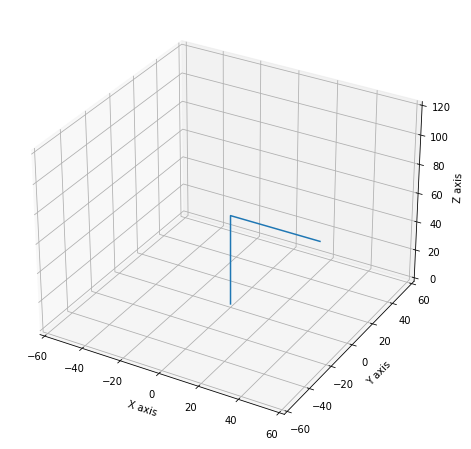

In [41]:
# This is just for testing the robot plotting mechanism

joints = [0, -pi/2, 0, pi/2, 0, 0]

plot_pose(joints, DH_params)
print(trans_EF_eval(joints, DH_params))

### Joint Limits

In this algorithm, we also implement joint limits. The following function simply saturates the joint values with respect to the joint limits. So, whenever a joint is over a limit, this function moves the joint back to the appropriate range.

In [12]:
# This takes the current joints and saturates them to the joint limits if they're out of bounds

def joint_limits(joints):
            
    # Joint 1
    if (joints[0] < -2*pi/3):
        
        joints[0] = -2*pi/3
        
    elif (joints[0] > 2*pi/3):
        
        joints[0] = 2*pi/3
        
    
    # Joint 2
    if (joints[1] < -0.95*pi):
        
        joints[1] = -0.95*pi
        
    elif (joints[1] > 0):
        
        joints[1] = 0
        
    # Joint 3
    if (joints[2] < -0.463*pi):
        
        joints[2] = -0.463*pi
        
    elif (joints[2] > 0.48*pi):
        
        joints[2] = 0.48*pi
        
    # Joint 4
    if (joints[3] < -0.97*pi):
        
        joints[3] = -0.97*pi
        
    elif (joints[3] > 0.97*pi):
        
        joints[3] = 0.97*pi
            
    return joints

    # Joint 5
    if (joints[4] < -3*pi/2):
        
        joints[4] = -3*pi/2
        
    elif (joints[4] > 3*pi/2):
        
        joints[4] = 3*pi/2
        
    # Joint 6
    if (joints[5] < -0.95*pi):
        
        joints[5] = -0.95*pi
        
    elif (joints[5] > 0.95*pi):
        
        joints[5] = 0.95*pi
            
    return joints

### Inverse Kinematics

The big difference in this inverse kinematic process compared to the original is that now we are concerned about not only the position, but also the orientation, of the end effector. However, there is a flag in the function header that can disregard orientation.

We rotate the end effector by finding the angular velocity it would take to move between the current and desired rotational matrices. We can then use the jacobian to convert that angular velocity to the corresponding joint movements required to rotate the end effector.

This inverse kinematics solver also uses the Damped Least Squares (DLS) pseudoinversion method to limit joint movement while solving, typically referred to as the Minimum Velocity Norm solution. Read more [here](https://link.springer.com/article/10.1007/BF01254007).

In [13]:
# joints_init is the current joint values for the robot
# target is the desired transformation matrix at the end effector
# set no_rotation to true if you only care about end effector position, not rotation
# set joint_lims to false if you want to allow the robot to ignore joint limits
# This is currently super slow since it's using all symbolic math
def i_kine(joints_init, target, DH_params, error_trace=False, no_rotation=False, joint_lims=True):
    
    joints = joints_init
    
    xr_desired = target[0:3,0:3]
    xt_desired = target[0:3,3]
    
    x_dot_prev = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
    e_trace = []
    
    iters = 0;
    
    print("Finding symbolic jacobian")
    
    # We only do this once since it's computationally heavy
    jacobian_symbolic = jacobian_expr(DH_params)
    
    print("Starting IK loop")
    
    final_xt = 0
    
    while(1):
        
        jac = jacobian_subs(joints, jacobian_symbolic)
        
        jac = np.array(jac).astype(np.float64)
        
        trans_EF_cur = trans_EF_eval(joints, DH_params)
                
        trans_EF_cur = np.array(trans_EF_cur).astype(np.float64)
        
        
        xr_cur = trans_EF_cur[0:3,0:3]
        xt_cur = trans_EF_cur[0:3,3]
        
        final_xt = xt_cur
                
        xt_dot = xt_desired - xt_cur
        
        
        # Find error rotation matrix
        R = xr_desired @ xr_cur.T
        
                            
        # convert to desired angular velocity
        v = np.arccos((R[0,0] + R[1,1] + R[2,2] - 1)/2)
        r = (0.5 * sin(v)) * np.array([[R[2,1]-R[1,2]],
                                       [R[0,2]-R[2,0]],
                                       [R[1,0]-R[0,1]]])
        
        
        # The large constant just tells us how much to prioritize rotation
        xr_dot = 200 * r * sin(v)
        
        # use this if you only care about end effector position and not rotation
        if (no_rotation):
            
            xr_dot = 0 * r
        
        xt_dot = xt_dot.reshape((3,1))
                
        x_dot = np.vstack((xt_dot, xr_dot))
                
        x_dot_norm = np.linalg.norm(x_dot)
        
        #print(x_dot_norm)
                
        if (x_dot_norm > 25):
            
            x_dot /= (x_dot_norm/25)
            
        x_dot_change = np.linalg.norm(x_dot - x_dot_prev)
                    
        # This loop now exits if the change in the desired movement stops changing
        # This is useful for moving close to unreachable points
        if (x_dot_change < 0.005):
            
            break;
            
        x_dot_prev = x_dot
            
        e_trace.append(x_dot_norm)
            
        Lambda = 12
        Alpha = 1
                        
        joint_change = Alpha * np.linalg.inv(jac.T@jac + Lambda**2*np.eye(DOF)) @ jac.T @ x_dot
        
        joints += joint_change
        
        if (joint_lims): joints = joint_limits(joints)
        
        iters += 1
                
    print("Done in {} iterations".format(iters))
    
    print("Final position is:")
    print(final_xt)
        
    return (joints, e_trace) if error_trace else joints

### Analysis

Let's test it out! The first thing you notice is that it's very, *very*, slow. That is because the inverse kinematics solver is still using a lot of symbolic math. I left it like this so the code can still output the symbolic jacobian as above, so you can copy it into your own code if you decide to refactor this code for another robot. If the jacobian were hard coded and just used numpy, the solver would be blazing fast. You can also make it faster by lowering the required accuracy before the solver exits, or by disregarding rotation and focusing only on position of the end effector.

Finding symbolic jacobian
Starting IK loop
Done in 74 iterations
Final position is:
[ 7.01608674  4.37378313 19.02753617]


Text(0.5, 1.0, 'Error Trace')

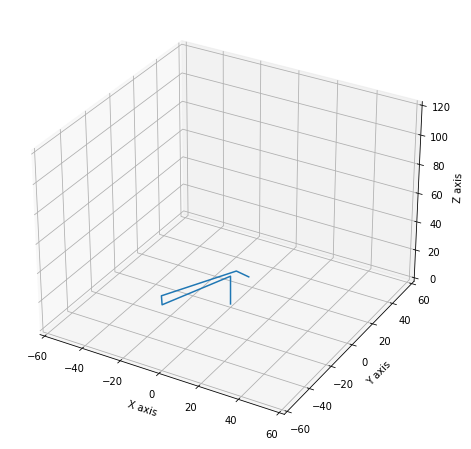

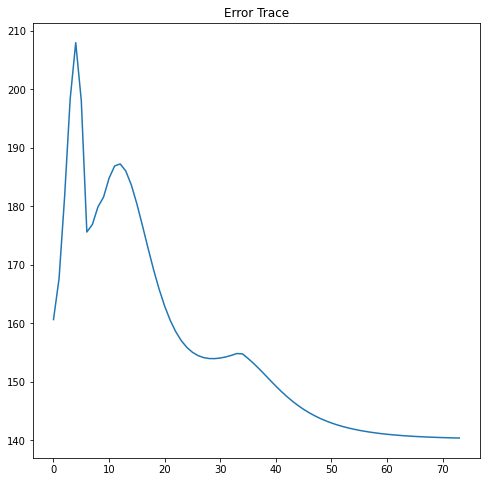

In [15]:
joints = np.array([[0.0],[-pi/2],[0.0],[pi/2],[0.0],[0.0]])

target = np.array([[1, 0, 0, 40],
                   [0, -1, 0, 10],
                   [0, 0, -1, 30],
                   [0, 0, 0, 1]])

new_j, e_trace = i_kine(joints, target, DH_params, error_trace=True)

plot_pose(new_j, DH_params)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')

One interesting thing we can do using a DLS solver is feed the robot points outside it's workspace. Previously the solver would not exit, but by reducing the joint velocity, it will instead move to the closest point it can to the target. We illustrate this below by turning off the rotation requirement and asking to robot to move to a point it cannot reach.

Finding symbolic jacobian
Starting IK loop
Done in 12 iterations
Final position is:
[6.62006400e+01 1.67581385e-03 6.72754676e+01]


Text(0.5, 1.0, 'Error Trace')

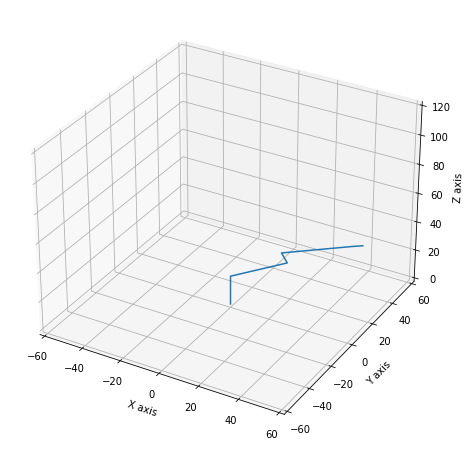

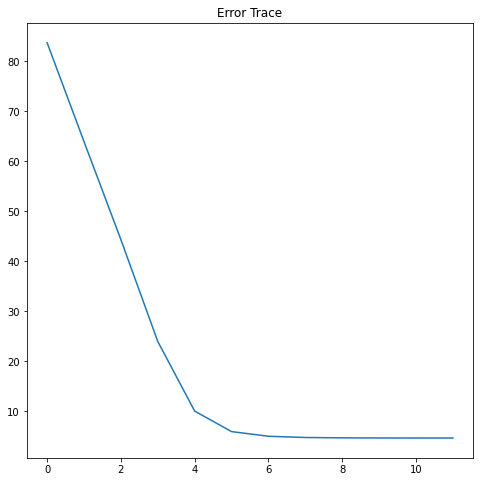

In [17]:
joints = np.array([[pi/2],[-pi/2],[0.0],[pi/2],[0.0],[0.0]])

target = np.array([[1, 0, 0, 70],
                   [0, -1, 0, 0],
                   [0, 0, -1, 70],
                   [0, 0, 0, 1]])

new_j, e_trace = i_kine(joints, target, DH_params, error_trace=True, no_rotation=True)

plot_pose(new_j, DH_params)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')